# Imports

In [1]:
import rdrobust
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Methods

Methods for Identification 

In [47]:
def sign(x):
    """
    This function computes the sign of the given observation.

    Parameters
    ----------
    x : int
        the observation to compute the sign.

    Returns
    -------
    sign: int 
        returns 0 if x is negative and 1 if nonnegative.
    """
    if x<0:
        return -1
    else:
        return 1

def treatment(x):
    """
     This function computes if an observation has received treatment.

    Parameters
    ----------
    x : int
        the observation to compute the treatment variable.

    Returns
    -------
    treatment: int 
        returns 0 if observation x does not receive treatment and 1 if it does receive treatment.
    """
    if x<0:
        return 0
    else:
        return 1

def indicator(x):
    """
     This indicator function computes if an observation is within a distance of the threshold.

    Parameters
    ----------
    x : int
        the observation to compute the indicator value.

    Returns
    -------
    treatment: int 
        returns 1 if observation x is within the distance and 0 if it is not.
    """
    if np.abs(x)<0.1:
        return 1
    else:
        return 0


def genT(X):
    T = {}
    for i in range(len(X)):
        T = np.append(T,treatment(X[i]))
    T = np.delete(T,0)
    return T
            


Methods for Generation of Outcomes: $Y_{i} = \mu(X_{i}) + \varepsilon_i$

$Y_{i}$ from Noak and Rothe 2023 donut RDD paper: 
$\newline \mu_N(x)=sign(x)*x^2-L*sign(x)((x-\delta*sign(x))^2-\delta^2*sign(x))*\boldsymbol{1}\{|x|<\delta\}$

In [3]:
def mu_noak(L,x):
    return sign(x)*np.power(x,2) - L*sign(x)*(np.power(x-0.1*sign(x),2)-np.power(0.1,2)*sign(x))*indicator(x)

def genY_noak(L,X,epsilon):
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_noak(L,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

Basic $Y_{i}$ just with simple treatment effect: $\quad \mu_{B}(x)= \tau t$

In [4]:
def mu_basic(tau,x): 
    return tau*treatment(x)

def genY_basic(tau,X,epsilon):
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_basic(tau,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

Basic linear outcomes ($Y_{i}$) plus simple treatment effect: $\quad \mu_{BL}(x)= \alpha + \beta x + \tau t$

In [5]:
def mu_basicLinear(tau,alpha,beta,x): 
    return alpha + beta*x + tau*treatment(x)

def genY_basicLinear(tau,alpha,beta,X,epsilon):
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_basicLinear(tau,alpha,beta,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

# Sample Generation 

Seed Set-up

In [6]:
sd = np.random.default_rng(seed=42)
print(sd)

Generator(PCG64)


Generation of the Outcomes ($Y_{i}$) given the different DGP's

In [32]:
def genY(name, X, tau=0, L=0, alpha=0, beta=0):
    epsilon = np.random.normal(0,0.5,n)
    if name == 'Noak':
        Y = genY_noak(L,X,epsilon)
    elif name == 'Basic':
        Y = genY_basic(tau,X,epsilon)
    elif name == 'Basic Linear':
        Y = genY_basicLinear(tau,alpha,beta,X,epsilon)
    else:
        return NameError('Type of GDP is not recognised')
    return Y

In [8]:

def genSample(name, n, tau=0, L=0, alpha=0, beta=0, printPlot=True):
    # Generate random variable: running variables (X), outcomes (Y), and treatments (T)
    X = np.random.uniform(-1,1,n)
    Y = genY(name, X, tau, L, alpha, beta)
    T = genT(X)

    # Create sample dataframe
    sample = pd.DataFrame({'Y': Y,'X': X,'T': T})

    # Print plot
    if printPlot == True:
        plt.scatter(X,Y,s=6)
        plt.xlabel('X')
        plt.ylabel('$Y_{i}$')

In [34]:
n = 1000
L = np.array([0,10,20,30,40])
tau = 2
a = -1
b = 1

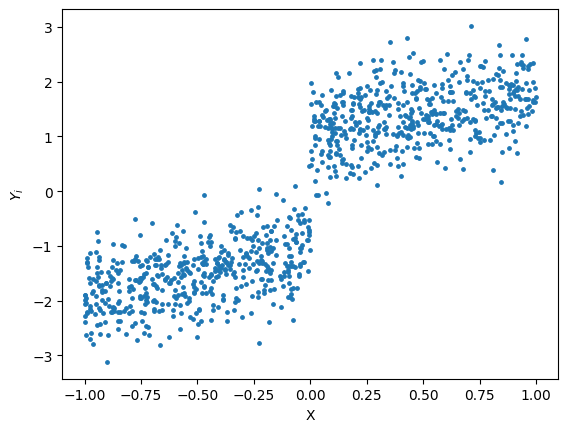

In [41]:
# Options are: 'Noak', 'Basic', 'Basic Linear'
genSample('Basic Linear',n,2,0,a,b,True)

# Treatment Effects

In [10]:
LATE = sample.Y*sample.T
LATE

NameError: name 'sample' is not defined